##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic regression: Predict fuel efficiency

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

在*回歸*問題中，目標是預測連續值的輸出，例如價格或概率。將此與*分類*問題進行對比，其目的是從類別列表中選擇一個類別（例如，圖片包含蘋果或橙子，識別圖片中的水果）。

本教程使用經典的 [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) 數據集，並演示如何構建模型來預測 1970 年代末和 1980 年代初的燃油效率汽車。為此，您將為模型提供該時間段內許多汽車的描述。此描述包括氣缸、排量、馬力和重量等屬性。

此示例使用 Keras API。 （訪問 Keras [教程](https://www.tensorflow.org/tutorials/keras) 和 [指南](https://www.tensorflow.org/guide/keras) 了解更多信息。）

In [ ]:
# Use seaborn for pairplot.
# !pip install -q seaborn

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# 使 NumPy 打印輸出更易於閱讀。
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.1


## 汽車 MPG 數據集

該數據集可從 [UCI 機器學習存儲庫](https://archive.ics.uci.edu/ml/) 獲得。


### 獲取數據
首先使用 pandas 下載並導入數據集：

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [4]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### 清理數據

數據集包​​含一些未知值：

In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

刪除這些行以使此初始教程保持簡單：

In [6]:
dataset = dataset.dropna()

`"Origin"` 列是分類的，而不是數字的。因此，下一步是使用 [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) 對列中的值進行一次熱編碼。

注意：您可以設置 `tf.keras.Model` 來為您進行這種轉換，但這超出了本教程的範圍。查看 [使用 Keras 預處理層分類結構化數據](../structured_data/preprocessing_layers.ipynb) 或 [加載 CSV 數據](../load_data/csv.ipynb) 教程以獲取示例。

In [7]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [8]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### 將數據拆分為訓練集和測試集

現在，將數據集拆分為訓練集和測試集。您將在模型的最終評估中使用測試集。

In [9]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### 檢查數據

查看訓練集中幾對列的聯合分佈。

第一行表明燃油效率 (MPG) 是所有其他參數的函數。其他行表示它們是彼此的函數。

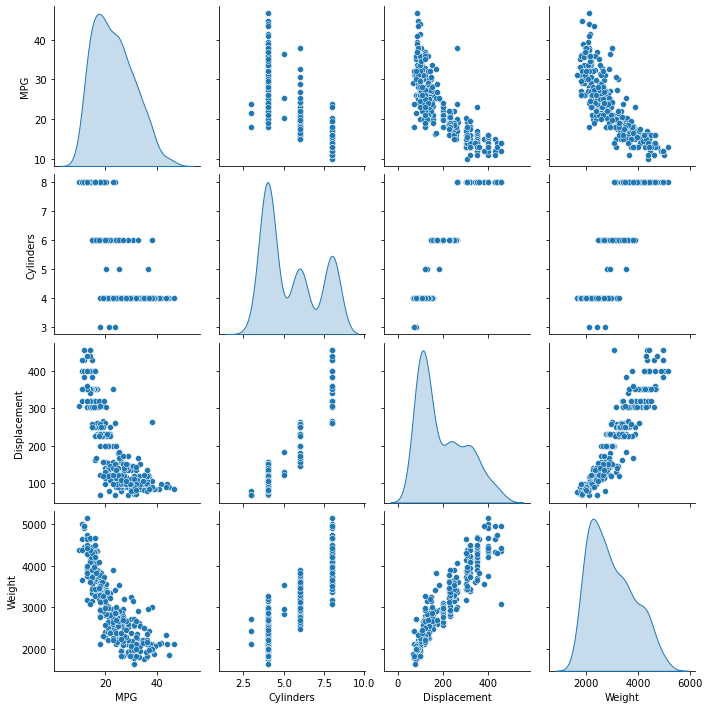

In [10]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

讓我們也檢查一下整體統計數據。請注意每個功能如何涵蓋非常不同的範圍：

In [15]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### 從標籤中拆分特徵

將目標值（即“標籤”）與特徵分開。此標籤是您將訓練模型進行預測的值。

In [16]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## 標準化

在統計表中，很容易看出每個特徵的範圍有多麼不同：

In [17]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


對使用不同比例和範圍的特徵進行歸一化是一種很好的做法。

這很重要的一個原因是因為特徵乘以模型權重。因此，輸出的規模和梯度的規模受到輸入規模的影響。

儘管模型*可能*在沒有特徵歸一化的情況下收斂，但歸一化使訓練更加穩定。
注意：對 one-hot 特徵進行標準化沒有任何好處——這里為了簡單起見。有關如何使用預處理層的更多詳細信息，請參閱[使用預處理層](https://www.tensorflow.org/guide/keras/preprocessing_layers)指南和[使用Keras預處理層分類結構化數據](../structured_data/preprocessing_layers.ipynb) 教程。

### 標準化層

`tf.keras.layers.Normalization` 是一種將特徵歸一化添加到模型中的簡潔明了的方法。

第一步是創建圖層：

In [19]:
normalizer = tf.keras.layers.Normalization(axis=-1)

然後，通過調用`Normalization.adapt`使預處理層的狀態適應數據：

In [20]:
normalizer.adapt(np.array(train_features))

計算均值和方差，並將它們存儲在層中：

In [21]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


當層被調用時，它返回輸入數據，每個特徵獨立標準化：

In [24]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## 線性回歸

在構建深度神經網絡模型之前，首先使用一個變量和多個變量進行線性回歸。

### 一個變量的線性回歸

從單變量線性回歸開始，從`Horsepower(馬力)`預測`MPG`。

使用 tf.keras 訓練模型通常從定義模型架構開始。使用 `tf.keras.Sequential` 模型，它[表示一系列步驟](https://www.tensorflow.org/guide/keras/sequential_model)。

單變量線性回歸模型有兩個步驟：
-使用 `tf.keras.layers.Normalization` 預處理層規範化 `'Horsepower'` 輸入特徵。
-應用線性變換 ($y = mx+b$) 以使用線性層 (`tf.keras.layers.Dense`) 產生 1 個輸出。

_inputs_ 的數量可以通過 `input_shape` 參數設置，也可以在模型第一次運行時自動設置。

首先，創建一個由“馬力”特徵組成的 NumPy 數組。然後，實例化 `tf.keras.layers.Normalization` 並將其狀態擬合到 `horsepower` 數據：

In [25]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

構建 Keras Sequential 模型：

In [26]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


該模型將從`Horsepower`預測`MPG`。

在前 10 個“馬力”值上運行未經訓練的模型。輸出不會很好，但請注意它的預期形狀為 `(10, 1)`：

In [27]:
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 1s 1s/step


array([[-0.378],
       [-0.213],
       [ 0.697],
       [-0.529],
       [-0.479],
       [-0.188],
       [-0.567],
       [-0.479],
       [-0.125],
       [-0.213]], dtype=float32)

構建模型後，使用 Keras `Model.compile` 方法配置訓練過程。最重要的編譯參數是 `loss` 和 `optimizer`，因為它們定義了優化的內容（`mean_absolute_error`）和如何（使用 `tf.keras.optimizers.Adam`）。

In [28]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

使用 Keras `Model.fit` 執行 100 個 epoch 的訓練：

In [29]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # 禁止記錄。
    verbose=0,
    # 計算 20% 的訓練數據的驗證結果。
    validation_split = 0.2)

CPU times: total: 15.5 s
Wall time: 12.5 s


使用 `history` 對像中存儲的統計數據可視化模型的訓練進度：

In [30]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.803764,4.194654,95
96,3.805395,4.182781,96
97,3.804661,4.200302,97
98,3.805991,4.181079,98
99,3.804209,4.189634,99


In [31]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

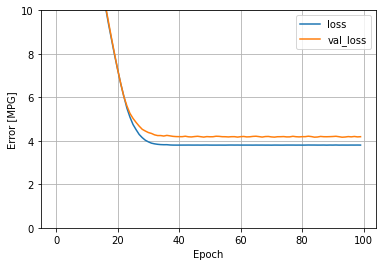

In [32]:
plot_loss(history)

收集測試集上的結果以備後用：

In [33]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

由於這是一個單變量回歸，因此很容易將模型的預測視為輸入的函數：

In [34]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 3ms/step


In [35]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

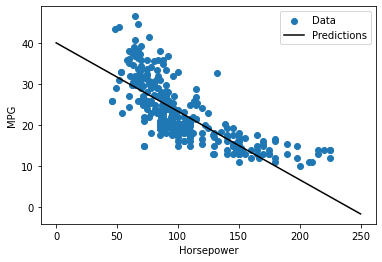

In [36]:
plot_horsepower(x, y)

### 具有多個輸入的線性回歸

您可以使用幾乎相同的設置來根據多個輸入進行預測。除了 $m$ 是矩陣而 $b$ 是向量之外，此模型仍然執行相同的 $y = mx+b$。

再次創建一個兩步 Keras Sequential 模型，第一層是您之前定義並適應整個數據集的 `normalizer` (`tf.keras.layers.Normalization(axis=-1)`)：

In [37]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

當您對一批輸入調用`Model.predict`時，它會為每個示例生成`units=1`輸出：

In [38]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 130ms/step


array([[-0.365],
       [ 0.316],
       [ 1.386],
       [ 0.773],
       [-1.203],
       [ 0.159],
       [-1.607],
       [-1.352],
       [-0.285],
       [-2.367]], dtype=float32)

當你調用模型時，它的權重矩陣將被構建——檢查`內核`權重（$y=mx+b$ 中的 $m$）是否具有 `(9, 1)` 的形狀：

In [39]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.09 ],
       [-0.234],
       [ 0.256],
       [ 0.732],
       [-0.772],
       [ 0.6  ],
       [-0.111],
       [-0.137],
       [ 0.219]], dtype=float32)>

使用 Keras `Model.compile` 配置模型並使用 `Model.fit` 訓練 100 個 epoch：

In [40]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [41]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # 禁止記錄。
    verbose=0,
    # 計算 20% 的訓練數據的驗證結果。
    validation_split = 0.2)

CPU times: total: 16.2 s
Wall time: 12.4 s


使用此回歸模型中的所有輸入可以實現比只有一個輸入的`horsepower_model`低得多的訓練和驗證錯誤：

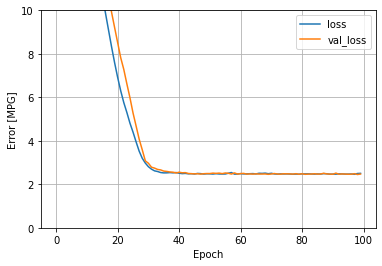

In [42]:
plot_loss(history)

收集測試集上的結果以備後用：

In [43]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## 使用深度神經網絡 (DNN) 進行回歸

在上一節中，您為單個和多個輸入實現了兩個線性模型。

在這裡，您將實現單輸入和多輸入 DNN 模型。

代碼基本相同，只是模型被擴展為包含一些“隱藏”的非線性層。這裡的名稱“隱藏”只是意味著不直接連接到輸入或輸出。

這些模型將包含比線性模型更多的層：

*標準化層，和以前一樣（對於單輸入模型使用`horsepower_normalizer`，對於多輸入模型使用`normalizer`）。
*兩個具有 ReLU (`relu`) 激活函數非線性的隱藏、非線性、`Dense` 層。
*一個線性“密集”單輸出層。

兩種模型都將使用相同的訓練過程，因此 `compile` 方法包含在下面的 `build_and_compile_model` 函數中。

In [44]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### 使用 DNN 和單個輸入進行回歸

創建一個 DNN 模型，僅將`Horsepower`作為輸入，將`horsepower_normalizer`（之前定義）作為規範化層：

In [45]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

這個模型比線性模型有更多的可訓練參數：

In [46]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


使用 Keras `Model.fit` 訓練模型：

In [47]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 16.6 s
Wall time: 13.2 s


這個模型比線性單輸入`horsepower_model`稍微好一點：

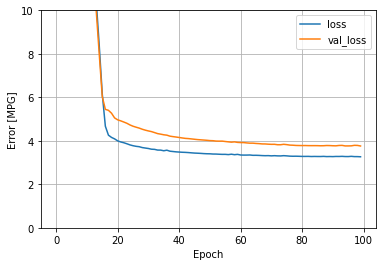

In [48]:
plot_loss(history)

如果您將預測繪製為`“馬力”`的函數，您應該注意到該模型如何利用隱藏層提供的非線性：


In [49]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 [==============================] - 0s 3ms/step


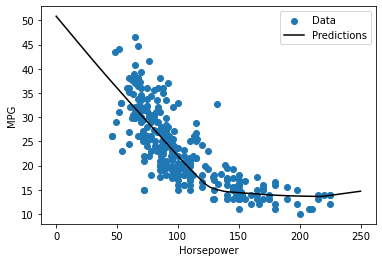

In [50]:
plot_horsepower(x, y)

收集測試集上的結果以備後用：

In [51]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

### 使用 DNN 和多個輸入進行回歸

使用所有輸入重複前面的過程。該模型的性能在驗證數據集上略有提高。

In [52]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [53]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 17.2 s
Wall time: 13.3 s


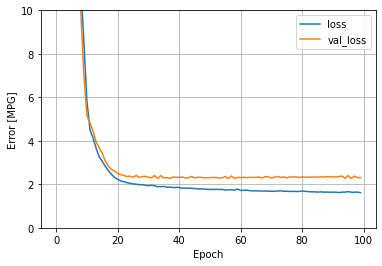

In [54]:
plot_loss(history)

在測試集上收集結果：

In [55]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## 表現

由於所有模型都經過訓練，您可以查看它們的測試集性能：

In [56]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.651195
linear_model,2.531204
dnn_horsepower_model,2.933089
dnn_model,1.727727


這些結果與訓練期間觀察到的驗證錯誤相匹配。

### 作出預測

您現在可以使用 Keras `Model.predict` 在測試集上使用 `dnn_model` 進行預測並查看損失：

3/3 [==============================] - 0s 5ms/step


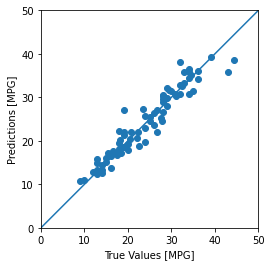

In [57]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


看來該模型的預測相當好。

現在，檢查錯誤分佈：

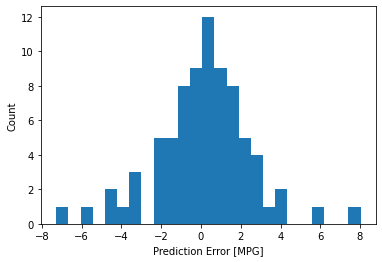

In [58]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

如果您對模型感到滿意，請將其保存以供以後使用 `Model.save`：

In [59]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


如果重新加載模型，它會給出相同的輸出：

In [60]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [61]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.651195
linear_model,2.531204
dnn_horsepower_model,2.933089
dnn_model,1.727727
reloaded,1.727727


## 結論

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

本筆記本介紹了一些處理回歸問題的技術。以下是一些可能會有所幫助的提示：

-均方誤差 (MSE) (`tf.keras.losses.MeanSquaredError`) 和平均絕對誤差 (MAE) (`tf.keras.losses.MeanAbsoluteError`) 是用於回歸問題的常見損失函數。 MAE 對異常值不太敏感。不同的損失函數用於分類問題。
-同樣，用於回歸的評估指標與分類不同。
-當數字輸入數據特徵具有不同範圍的值時，每個特徵應獨立縮放到相同範圍。
-過度擬合是 DNN 模型的常見問題，儘管在本教程中不是問題。訪問 [Overfit and underfit](overfit_and_underfit.ipynb) 教程以獲得更多幫助。